# Adding in Construction Year

Previously, we omitted construction year from our models because about 1/3 of the data was missing, and there was not an easy way to impute the year. As a result, the feature was omitted to avoid having to discard 1/3 of the data.

However, we see from our exploratory data analysis that construction year is likely to have an effect on whether a water point is functional or not. Here, we conduct modeling by including the construction year and discarding the rows of data where this feature is missing.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import math
import re
from scipy import stats
from sklearn import preprocessing

import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [2]:
# Code taken from sklearn: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
data = pd.read_csv('water4_scaled.csv')

In [47]:
# Prepare original data

data = data.drop(['wpt_name', 'subvillage', 'region_code', 'district_code', 'recorded_by', 'scheme_management',
                  'scheme_name', 'extraction_type', 'payment', 'water_quality', 'quantity_group', 'source', 
                  'waterpoint_type_group', 'installer_group', 'installer', 'funder',
                  'date_recorded', 'amount_tsh', 'gps_height','extraction_type_group', 
                  'num_private', 'lga', 'ward'], axis=1)

data3 = data[data['permit'].isnull()==False]
data3 = data3[data3['public_meeting'].isnull()==False]
data3 = data3[data3['construction_year']!=0]

data3 = pd.get_dummies(data3, columns=['basin', 'extraction_type_class', 'funder_type', 'installer_final', 
                                       'management', 'management_group', 'month-year', 'payment_type',
                                       'permit', 'public_meeting', 'region', 'source_class', 'source_type', 
                                       'waterpoint_type', 'year', 'quality_group', 'quantity']) 




In [59]:
data3.shape[0]

34701

In [60]:
data3['status_group'].value_counts()

functional                 19782
non functional             12638
functional needs repair     2281
Name: status_group, dtype: int64

In [50]:
# Isolate Dependent Variable
well = data3['status_group']
# Isolate Independent Variable
predictors = data3.drop(['status_group', 'id', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(predictors, well, test_size = 0.25, random_state = 0)

In [52]:
# Run Random Forest`
clf11 = RandomForestClassifier(max_depth=40, max_features=30, min_samples_leaf=2, n_estimators=13)
clf11 = clf11.fit(x_train, y_train)

In [53]:
y_pred1 = clf11.predict(x_test)

In [54]:
f1_score(y_test, y_pred1, average='weighted') 

0.81086031984659079

Confusion matrix, without normalization
[[4505   94  379]
 [ 324  166  110]
 [ 621   33 2444]]


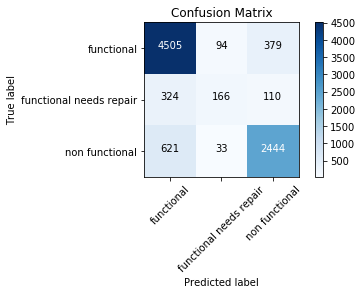

In [56]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred1), 
                      classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=False,
                      title = 'Confusion Matrix') 

Normalized confusion matrix
[[ 0.90498192  0.01888309  0.07613499]
 [ 0.54        0.27666667  0.18333333]
 [ 0.2004519   0.01065203  0.78889606]]


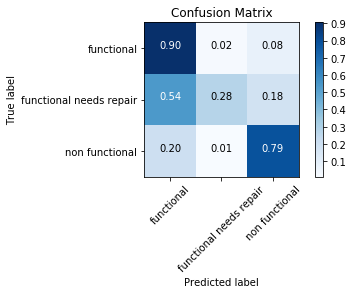

In [55]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred1), 
                      classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')  

# Upsampling
Let's try upsampling minority classes to increase the f1 score

In [145]:
# Upsample
data_functional3 = data3[data3['status_group']=='functional']
data_repair3 = data3[data3['status_group']=='functional needs repair']
data_nonfunc3 = data3[data3['status_group']=='non functional']

# Upsample both non functional and water points needing repair
data_repair_upsample3 = resample(data_repair3, replace = True, 
                                n_samples=data_functional3.shape[0], 
                                random_state=123)

data_nonfunc_upsample3 = resample(data_nonfunc3, replace = True, 
                                n_samples=data_functional3.shape[0], 
                                random_state=123)


data_sampled3 = pd.concat([data_functional3, data_repair_upsample3, data_nonfunc_upsample3]) 

In [58]:
# Double check data distribution
data_sampled3['status_group'].value_counts()

functional needs repair    19782
functional                 19782
non functional             19782
Name: status_group, dtype: int64

In [61]:
# Isolate Dependent Variable
well4 = data_sampled3['status_group']

# Isolate Independent Variable
predictors4 = data_sampled3.drop(['status_group', 'id', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)

# Split into training and test sets
x_train4, x_test4, y_train4, y_test4 = train_test_split(predictors4, well4, test_size = 0.25, random_state = 0)

In [62]:
clf2 = RandomForestClassifier(max_depth=40, max_features=30, min_samples_leaf=2, n_estimators=13)
clf2 = clf2.fit(x_train4, y_train4)


In [64]:
# Make prediction using testing sample that was not upsampled
y_pred2 = clf2.predict(x_test)

In [65]:
f1_score(y_test, y_pred2, average='weighted')

0.91512490983847028

Confusion matrix, without normalization
[[4562  210  206]
 [   2  596    2]
 [ 263   69 2766]]


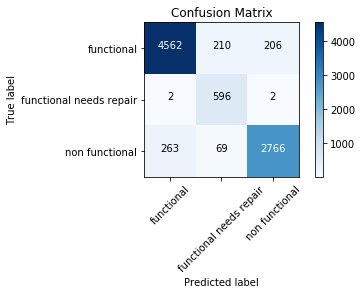

In [66]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred2), 
                      classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=False,
                      title = 'Confusion Matrix') 

Normalized confusion matrix
[[ 0.9164323   0.04218562  0.04138208]
 [ 0.00333333  0.99333333  0.00333333]
 [ 0.08489348  0.02227243  0.89283409]]


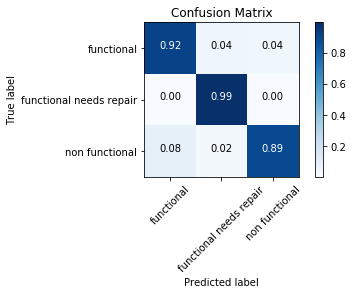

In [67]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred2), 
                      classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix') 

Including construction year does not seem to make too much of a difference.

In [104]:
# Which features are important?
imp = clf2.feature_importances_

In [117]:
feature_importances = pd.DataFrame(clf2.feature_importances_,
                                   index = x_train4.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [119]:
# 20 most important features
feature_importances[0:20]

,importance
longitude,0.099675
latitude,0.068397
quantity_dry,0.063309
gps_height_rob,0.061981
construction_year,0.061515
population,0.047086
extraction_type_class_gravity,0.033849
quantity_enough,0.032112
amount_tsh_rob,0.031827
extraction_type_class_other,0.027651


In [137]:
# Plot feature importance of 20 most important features
std = np.std([tree.feature_importances_ for tree in clf2.estimators_],
             axis=0)
indices = feature_importances.index
ind = np.argsort(imp)[::-1]

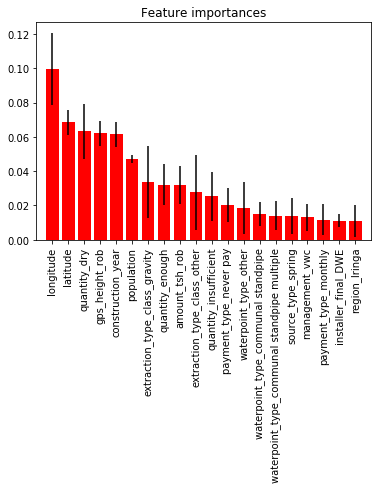

In [140]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(20), feature_importances['importance'][:20],
       color="r", yerr=std[ind][:20], align="center")
plt.xticks(range(20), indices, rotation='vertical')
plt.xlim([-1, 20])
plt.show()

In terms of the features that have the most influence:
* Location matters (longitude, latitude have the most weight)
* GPS Height (perhaps how high or low a water point is compared to a certain ground level)
* Factors that are more obviously indicative of whether a water point is functional or not
    * Quantity of water within the water point (whether the water point is dry or not)
    * Population around the water point (may correlate with quantity of water available at water point)
    * amount_tsh - amount of water available
* Construction Year
* Extraction Type
* Payment Type - Never Pay: Likely that if people never paid, the water point is likely to be non functional
* Water point type - whether it is a hand pump or standpipe seems to carry more weight

Our exploratory data analysis had observed that some of the above features would be indicative of the water point class, including construction year, extraction type, quanity group (quantity of water available), GPS Height, and Population. 

Initially, we had also believed that funder and installer could be a big factor, but as there were a huge number of funders and installers, there was very little data for each funder and installer. It appears that even our categorization did not help to pull out the influence of these features, perhaps due to the fact that a large number still fell within the "Other" category.

# Upsampling 2
We give upsampling a second try - apparently, by upsampling on the entire dataset instead of just on the training set, we get artificially high scores on the test set. Here, we upsample on only the training data to get more accurate scores when testing.

In [146]:
# Shuffle data and split into training and test sets
data4 = data3.sample(frac=1)

In [147]:
data4.shape

(34701, 163)

In [152]:
# Isolate into training and test set
train = data4[:26026]
test = data4[26026:]

In [150]:
# Upsample
data_functional4 = train[train['status_group']=='functional']
data_repair4 = train[train['status_group']=='functional needs repair']
data_nonfunc4 = train[train['status_group']=='non functional']

# Upsample both non functional and water points needing repair
data_repair_upsample4 = resample(data_repair4, replace = True, 
                                n_samples=data_functional4.shape[0], 
                                random_state=123)

data_nonfunc_upsample4 = resample(data_nonfunc4, replace = True, 
                                n_samples=data_functional4.shape[0], 
                                random_state=123)


data_sampled4 = pd.concat([data_functional4, data_repair_upsample4, data_nonfunc_upsample4]) 

In [151]:
data_sampled4['status_group'].value_counts()

functional needs repair    14835
functional                 14835
non functional             14835
Name: status_group, dtype: int64

In [167]:
x_train2 = data_sampled4.drop(['status_group', 'Unnamed: 0', 'Unnamed: 0.1', 'id'], axis=1)
y_train2 = data_sampled4['status_group']
x_test2 = test.drop(['status_group', 'Unnamed: 0', 'Unnamed: 0.1', 'id'], axis=1)
y_test2 = test['status_group']

In [162]:
clf2 = RandomForestClassifier(max_depth=40, max_features=30, min_samples_leaf=2, n_estimators=13)
clf4 = clf2.fit(x_train2, y_train2)

In [168]:
# Make prediction using testing sample that was not upsampled
y_pred4 = clf4.predict(x_test2)

In [169]:
f1_score(y_test2, y_pred4, average='weighted')

0.79258642631090537

As we can see, we indeed receive artifically high test scores by upsampling the test set as well.

Confusion matrix, without normalization
[[4142  345  460]
 [ 206  291   76]
 [ 603  147 2405]]


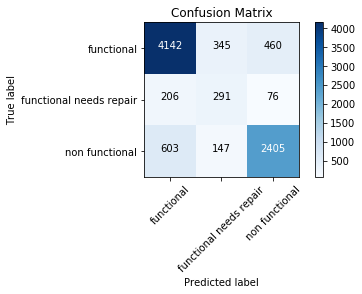

In [172]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test2, y_pred4), 
                      classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=False,
                      title = 'Confusion Matrix') 

Normalized confusion matrix
[[ 0.83727512  0.06973924  0.09298565]
 [ 0.35951134  0.5078534   0.13263525]
 [ 0.1911252   0.04659271  0.76228209]]


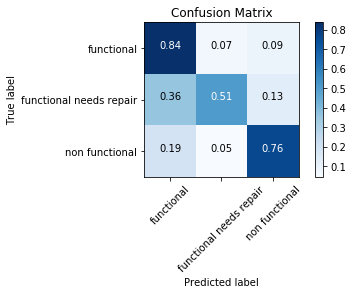

In [173]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test2, y_pred4), 
                      classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix') 

While the f1 score is still around 80%, similar to when there was no upsampling, the recall score for "functional needs repair" is greatly improved, from 28% to 51%, making this the more useful model.

In [177]:
# What are important features?
imp2 = clf4.feature_importances_
feature_importances2 = pd.DataFrame(clf4.feature_importances_,
                                   index = x_train2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

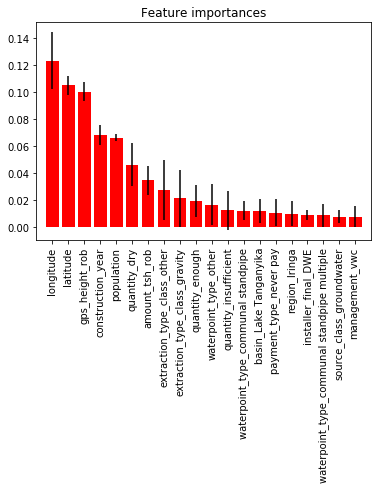

In [179]:
# Plot feature importance of 20 most important features
std2 = np.std([tree.feature_importances_ for tree in clf4.estimators_],
             axis=0)
indices2 = feature_importances2.index
ind2 = np.argsort(imp2)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(20), feature_importances2['importance'][:20],
       color="r", yerr=std[ind2][:20], align="center")
plt.xticks(range(20), indices2, rotation='vertical')
plt.xlim([-1, 20])
plt.show()

Correcting for the upsampling, the feature importance remains similar.

# Using SMOTE
We can also try using SMOTE to do the upsampling.

In [180]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 0, ratio='all')

In [181]:
# train on upsampled data
x_train_sm, y_train_sm = sm.fit_sample(x_train, y_train)

In [182]:
unique, counts = np.unique(y_train_sm, return_counts=True)
dict(zip(unique, counts))

{'functional': 14804,
 'functional needs repair': 14804,
 'non functional': 14804}

In [183]:
clf3 = clf2.fit(x_train_sm, y_train_sm)

In [184]:
y_pred3 = clf3.predict(x_test)

In [185]:
f1_score(y_test, y_pred3, average='weighted')

0.8062481452077398

Normalized confusion matrix
[[ 0.85737244  0.05062274  0.09200482]
 [ 0.40666667  0.435       0.15833333]
 [ 0.17979342  0.02582311  0.79438347]]


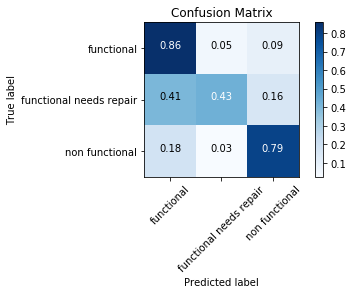

In [102]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred3), 
                      classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix') 

When we use SMOTE, Random Forest predicts 'functional needs repair' better than if we were to not upsample, but not as well as if we were to use raw upsampling. 

This may reflect that SMOTE takes care of overfitting for the 'functional needs repair' category. Using upsampling without SMOTE, each data record under 'functional needs repair' category needed to be replicated about 10 times in order for this class to have the same size as the 'functional' class, leading to potential overfitting for the test set.

In [186]:
# What are the most important features under SMOTE?
imp3 = clf3.feature_importances_

In [190]:
feature_importances3 = pd.DataFrame(clf3.feature_importances_,
                                   index = x_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

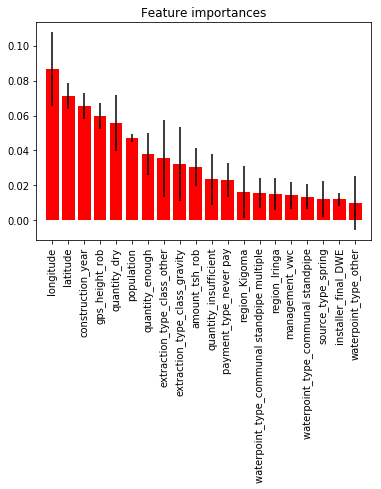

In [191]:
# Plot feature importance of 20 most important features
std3 = np.std([tree.feature_importances_ for tree in clf3.estimators_],
             axis=0)
indices3 = feature_importances3.index
ind3 = np.argsort(imp3)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(20), feature_importances3['importance'][:20],
       color="r", yerr=std[ind3][:20], align="center")
plt.xticks(range(20), indices3, rotation='vertical')
plt.xlim([-1, 20])
plt.show()